# Final K-fold Model for the Kaggle State Farm Competition

IMPORT AND INTIALIZATIONS

In [1]:
import numpy as np
import random
import cv2
import math
import pickle
import os
import pandas as pd
import datetime
import matplotlib.pyplot as plt

from glob import glob
from PIL import ImageFile 
ImageFile.LOAD_TRUNCATED_IMAGES = True 
from sklearn.model_selection import KFold 
from sklearn.metrics import log_loss
from sklearn.datasets import load_files
from keras import optimizers
from keras.optimizers import SGD
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.layers import GlobalMaxPooling2D, BatchNormalization,Dropout, Flatten, Dense, Input
from keras.models import Sequential,Model,model_from_json
from keras.preprocessing import image    
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, Callback,ModelCheckpoint

Using TensorFlow backend.


PREPROCESSING METHODS

In [2]:

# Reads images from path and resizes them to 224x224
# Returns resized image
def read_resize_images(path):
    img = cv2.imread(path)
    img_rows, img_cols=224,224
    resized = cv2.resize(img, (img_rows, img_cols))
    return resized

# Reads the drivers_img_list csv file
# Returns driver data, driver classification
def get_driver_data():
    dr = dict()
    clss = dict()
    path ='Data/driver_imgs_list.csv'
    print('Read driver data')
    f = open(path, 'r')
    line = f.readline()
    while (1):
        line = f.readline()
        if line == '':
            break
        arr = line.strip().split(',')
        dr[arr[2]] = arr[0]
        if arr[0] not in clss.keys():
            clss[arr[0]] = [(arr[1], arr[2])]
        else:
            clss[arr[0]].append((arr[1], arr[2]))
    f.close()
    return dr, clss

# Method used to retrieve all Train Dataset images
# Returns data, labels, image names, driver in image, list of unique drivers  
def load_train():
    driver_file=[]
    driver_target=[]
    driver_id=[]
    driver_file_id=[]
    # calls the method that reads the provided CSV file
    driver_data, dr_class = get_driver_data()
    print('driver data and class sample',len(driver_data),len(dr_class))
    for j in range(10):
        print('Load folder c{}'.format(j))
        path = os.path.join( 'Data', 'imgs', 'train', 'c' + str(j), '*.jpg')
        data = glob(path)
        for p in data:
            
            driver_file.append(read_resize_images(p))
            driver_target.append(j)
            base = os.path.basename(p)
            driver_file_id.append(base)
            driver_id.append(driver_data[base])
            
    unique_drivers = sorted(list(set(driver_id)))
    return driver_file,driver_target,driver_file_id,driver_id,unique_drivers

# Saves data into a file, in the specified path 
def cache_data(data, path):
    if os.path.isdir(os.path.dirname(path)):
        file = open(path, 'wb')
        pickle.dump(data, file)
        file.close()

# Loads data from cache file    
# Returns saved data
def restore_data(path):
    data = dict()
    if os.path.isfile(path):
        file = open(path, 'rb')
        data = pickle.load(file)
    return data

PROCESSING METHODS

In [3]:
# Copies the required drivers data and labels into new arrays based on the driver list 
# Returns data, target (both return as uint8 strings)
def get_selected_drivers(train_data, train_target, driver_id, driver_list):
    data = []
    target = []
    
    for i in range(len(train_data)):
        if driver_id[i] in driver_list:
            data.append(train_data[i])
            target.append(train_target[i])
    
    # Delete variables accessing data 
    del train_data
    del train_target
    del driver_id
    del driver_list
    data = np.array(data,dtype=np.uint8)
    target = np.array(target,dtype=np.uint8)
    return data, target

# Copies the required drivers data and labels into new arrays based on the driver list 
# Returns data, target,test index (data returns as float32)
def get_val_selected_drivers(val_data, val_target, driver_id, driver_list):
    data = []
    target = []
    index = []
   
    for i in range(len(val_data)):
        if driver_id[i] in driver_list:
            data.append(val_data[i])
            target.append(val_target[i])
            index.append(i)
            
    # Delete variables accessing data        
    del val_data
    del val_target
    del driver_id
    del driver_list
    data = np.array(data,dtype=np.float32)
    target = np.array(target,dtype=np.uint8)
    index = np.array(index)
    return data, target, index

# Class used to visualize the train vs validation loss plot (per epoch)
class PlotLosses(Callback):
    # Initializes plot on first epoch
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []
        
    # Prints a plot at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend(['train', 'test'], loc='upper left')
        plt.show();

# Splits a list into (specified) parts
def split_list(l,size):
    return [l[i*len(l) // size: (i+1)*len(l) // size] for i in range(size)]

# Converts dictionary to list
def get_val_predictions(train_data, pred_dict):
    val_pred = []
    for i in range(len(train_data)):
        val_pred.append(pred_dict[i])
    
    del train_data
    del pred_dict
    return val_pred


# Merges multiple prediction outputs into one by dividing predictions by its mean
# Returns a list
def merge_prediction_outputs(data, nfolds):
    a = np.array(data[0])
    for i in range(1, nfolds):
        a += np.array(data[i])
    a /= nfolds
    
    return a.tolist()


POST-PROCESSING METHODS

In [4]:
# Combines two lists together
# Returns one list
def append_chunk(main, part):
    for p in part:
        main.append(p)
        
    return main

# Method used to retrieve all Test Dataset image paths 
# Splits the images into specified size
# Reads and resizes images of the split
# Returns the chunks  images, image names
def load_test_parts(part,splits):
    path='Data/imgs/test/*'
    data=glob(path)
    driver_file=[]
    driver_id=[]  
    test_chunks=split_list(data,splits)
    
    for p in test_chunks[part]:
        driver_file.append(read_resize_images(p))
        driver_id.append(os.path.basename(p))

    return driver_file,driver_id

# creates the submission file from provided predictions
def create_submission(predictions, test_id, loss,model_name):
    print('Started building csv file')
    result = pd.DataFrame(predictions, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    result.insert(loc=0, column='img', value=test_id)
    now = datetime.datetime.now()
    if not os.path.isdir('submissions'):
        os.mkdir('submissions')
    suffix = str(round(loss, 6)) + '_' + str(now.strftime("%Y-%m-%d-%H-%M"))
    subfile = os.path.join('submissions', 'submission' +model_name+ '_'  +suffix + '.csv')
    result.to_csv(subfile, index=False)
    print("successfully created submission")   
    
# Creates Test Dataset predictions
#  Loads the model and weights
#  Loads test images
#  generates predictions
#  Merges predictions of all K-folds into one output file
#  Returns prediction output, test image names
def run_model_submission(model_name,nfolds):    
    
    print('Model: ', model_name)
    
    test_splits=5
    num_fold=0
    
    full_pred=[]
    full_test_id=[]
    # For-loop for each fold
    for i in range(nfolds):
        
        # Loads the model and weights
        model= get_model_arch(model_name)
        num_fold+=1
        print('Fold No. ',num_fold)
        kfold_weights_path = os.path.join('cache', 'weights_kfold_augmented_' + model_name + '_' + str(num_fold) + '.h5')
        model.load_weights(kfold_weights_path)
        
        predictions=[]
        # For loop each test split
        for x in range(test_splits):
            print('iteration: ',x)
           # cache_path=None
            part=x+1
            
            # load test images of the split 
            cache_path= os.path.join('cache','test_224_part'+str(part)+'.dat')

            if not os.path.isfile(cache_path):
                print('building test cache')
                test_files,test_id = load_test_parts(x,test_splits)
                cache_data((test_files,test_id),cache_path)
                print('test cache built')
            else:
                print('Restore test from cache')
                (test_files,test_id)=restore_data(cache_path)

            test_files=np.array(test_files,dtype=np.uint8)    
            test_files = test_files.reshape(test_files.shape[0], img_rows, img_cols,img_channel)
            test_files = test_files.astype('float32')
            
            # Preprocess test images to match train dataset
            test_files/=255
            # Generate Test prediction
            prediction=model.predict(test_files,  batch_size=batch_size)
            
            # Add chunk to main list
            predictions=append_chunk(predictions,prediction)
            if num_fold==1:
                full_test_id=append_chunk(full_test_id,test_id)
            
            del test_files
    
        full_pred.append(predictions)
        
        
    # Merges all predictions into one    
    result=merge_prediction_outputs(full_pred, nfolds)   
       
    return result,full_test_id

# Loops the run_model_submission method by the number of models
# Prediction output of each loop is merged into one
# Creates the final output file by Giving the prediction output to the create_submission method
def test_set_submission(model_list,nfolds,score):
    multi_model=[]
    test_id=None
    model_text=''
    for i in range(len(model_list)):
        result,test_id =run_model_submission(model_list[i],nfolds)
        multi_model.append(result)
        create_submission(result,test_id,score,model_list[i])
        model_text=model_text+'_'+model_list[i]
        
    num_models=len(multi_model)   
    result=merge_prediction_outputs(multi_model, num_models)
    
    create_submission(result,test_id,score,model_text) 




VISUALIZATION METHODS

In [5]:

# Creates the sample visualization images of all individual models and including combined model
def visualize_val_images(model_list,all_model_predictions,train_files,train_targets,comb_pred):
    #Name the labels 
    y_labels = ['safe driving', 'texting - right', 'talking on the phone - right', 'texting - left',
                'talking on the phone - left', 'operating the radio', 'drinking', 'reaching behind',
                'hair and makeup', 'talking to passenger']
    # Convert all train images to np array
    train_files=np.array(train_files)
   
    # Create the label/title of the combined model
    # Adds label of models to a new list
    model_label_list=[]
    multi_model_text=''
    for i in range(len(model_list)):
            model_label_list.append(model_list[i])
            if len(model_list)>1:
                multi_model_text+=model_list[i]
                if len(model_list)!= i:
                    multi_model_text+=' '  
    #add the combined predictions to all model predictions for visualization
    if len(model_list)>1:
        model_label_list.append(multi_model_text)
        all_model_predictions.append(comb_pred)
        
    # Set number of sample images    
    np.random.seed(51)
    random_data=np.random.choice(train_files.shape[0], size=10, replace=False)
    # Loops visualization for all models
    for x in range(len(all_model_predictions)):
        
        fig = plt.figure(figsize=(20, 10))
        for i, idx in enumerate(random_data):
            ax = fig.add_subplot(2, 5, i + 1, xticks=[], yticks=[])
            ax.imshow(np.squeeze(train_files[idx]))
            true_idx = np.argmax(train_targets[idx])
            pred_idx = np.argmax(all_model_predictions[x][idx])
            ax.set_title("{} ({})".format(y_labels[pred_idx], y_labels[true_idx]),
                         color=("green" if pred_idx == true_idx else "red"))
        fig.suptitle(model_label_list[x], fontsize=25)
        plt.show()
        
 # Creates the validation loss plot of all models   
def visualize_val_score(model_list,val_scores,nfolds):
    plt.figure(figsize=(9,4))
    model_label_list=[]
    multi_model_text=''
    # Plots the model validation loss for each fold
    # Creates combined model text
    # Adds model labels to new list
    for i in range(len(model_list)):
        plt.plot(range(1,nfolds+1),val_scores[i])
        model_label_list.append(model_list[i])
        if len(model_list)>1:
                multi_model_text+=model_list[i]
                if len(model_list)!= i:
                    multi_model_text+=' '        
    # Adds the combined model label to labels list
    # Plots the combined model
    if len(model_list)>1:
        model_label_list.append(multi_model_text)
        avg_val_score=[]
        for i in range(nfolds):
            avg_score=0
            for x in range(len(model_list)):
                avg_score+=val_scores[x][i]
            avg_score/=len(model_list)
            avg_val_score.append(avg_score)

     
        plt.plot(range(1,nfolds+1),avg_val_score)    

    plt.title('Model Validation Loss of All Folds')
    plt.ylabel('Loss')
    plt.xlabel('Folds')
    
    plt.legend(model_label_list, loc='upper left')
    plt.show()


ARCHITECTURE METHODS

In [6]:
# Creates the VGG19 model architecture 
# Returns compiled model architecture
def VGG19_arch():
    #Calls the Keras application model with pre trained weights
    base_model = VGG19(input_shape=(224,224,3),weights='imagenet', include_top=False)

    #Additional model layers
    x = base_model.output
    x = GlobalMaxPooling2D()(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(10, activation='softmax')(x)  
    
    model = Model(inputs=base_model.input, outputs=predictions)
    #Model compilation
    model.compile(optimizer=SGD(lr=0.0009,momentum=0.9,nesterov=True),loss='categorical_crossentropy')
    
    return model

# Creates the ResNet50 Model architecture
# Returns compiled model architecture
def ResNet50_arch():
    #Calls the Keras application model with pre trained weights
    base_model = ResNet50(input_shape=(224,224,3),weights='imagenet', include_top=False)
    
    #Additional model layers
    x = base_model.output
    x = GlobalMaxPooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    predictions = Dense(10, activation='softmax')(x)  
   
    model = Model(inputs=base_model.input, outputs=predictions)
    #Model compilation
    model.compile(optimizer=SGD(lr=0.001, momentum=0.9,nesterov=True), loss='categorical_crossentropy')
   
    return model
 
# Simplifies the calling of a model by accessing the model equivalent of the string
# returns model architecture
def get_model_arch(model_name):
    model_arch=None
    if model_name=='VGG19':
        model_arch=VGG19_arch()
    elif model_name=='ResNet50':
        model_arch=ResNet50_arch()
    else:
        print('No model with such name')
    return model_arch

TRAINING PARAMETERS

In [7]:
# Some parameter intializations

img_rows=224
img_cols=224
img_channel=3  


batch_size=32
nfolds=10
epochs=20

# list specifying the models we want to train
model_list=[
   'ResNet50'
   ,
     'VGG19'
           ]
# Variable that specifies if we want to make a submission output or not
build_submission=True

MODEL TRAINING AND TESTING SEGMENT

Model:  ResNet50
Restore train from cache
Start KFold number 1 of 2
Train drivers:  ['p002', 'p021', 'p035', 'p042', 'p047', 'p049', 'p050', 'p051', 'p052', 'p064', 'p066', 'p075', 'p081']
Test drivers:  ['p012', 'p014', 'p015', 'p016', 'p022', 'p024', 'p026', 'p039', 'p041', 'p045', 'p056', 'p061', 'p072']
Score log_loss:  0.139820496646
Start KFold number 2 of 2
Train drivers:  ['p012', 'p014', 'p015', 'p016', 'p022', 'p024', 'p026', 'p039', 'p041', 'p045', 'p056', 'p061', 'p072']
Test drivers:  ['p002', 'p021', 'p035', 'p042', 'p047', 'p049', 'p050', 'p051', 'p052', 'p064', 'p066', 'p075', 'p081']
Score log_loss:  0.00677256036012
train length:  22424
Validation Score Average  0.073296528503
(validation score) Final log_loss: 0.07343892729314297, nfolds: 2 epoch: 20
Model:  VGG19
Restore train from cache
Start KFold number 1 of 2
Train drivers:  ['p002', 'p021', 'p035', 'p042', 'p047', 'p049', 'p050', 'p051', 'p052', 'p064', 'p066', 'p075', 'p081']
Test drivers:  ['p012', 'p014', 'p

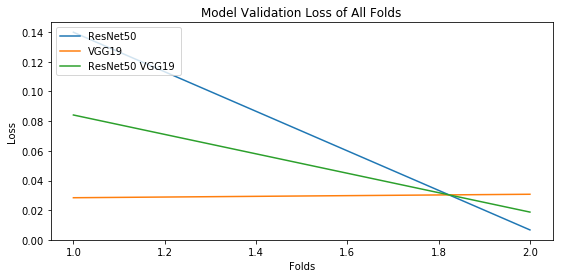

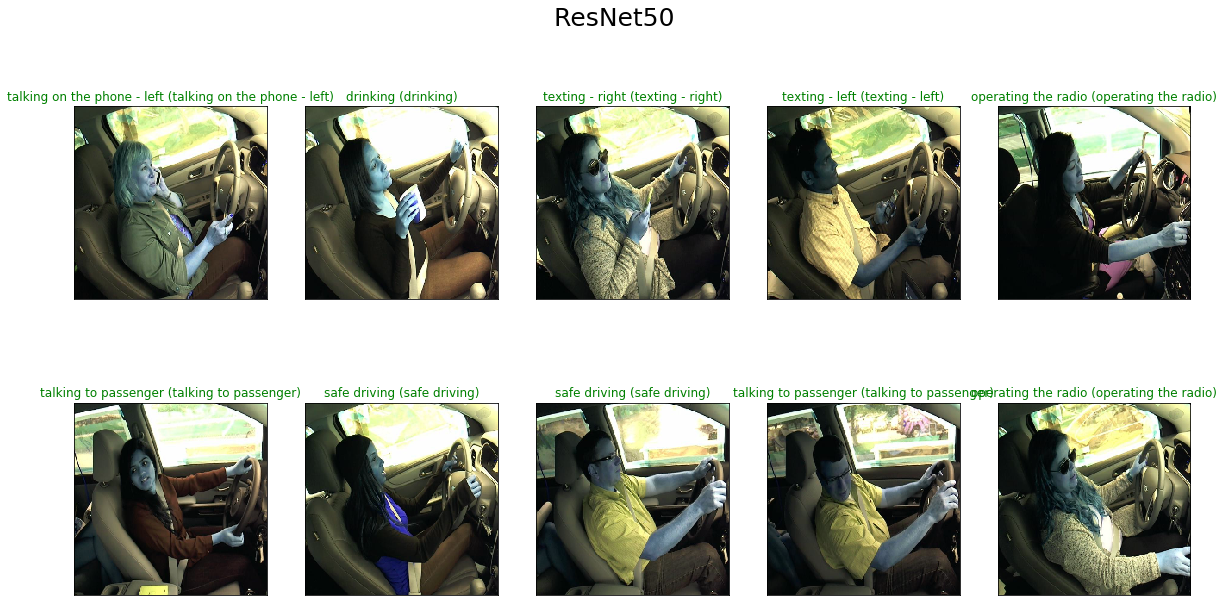

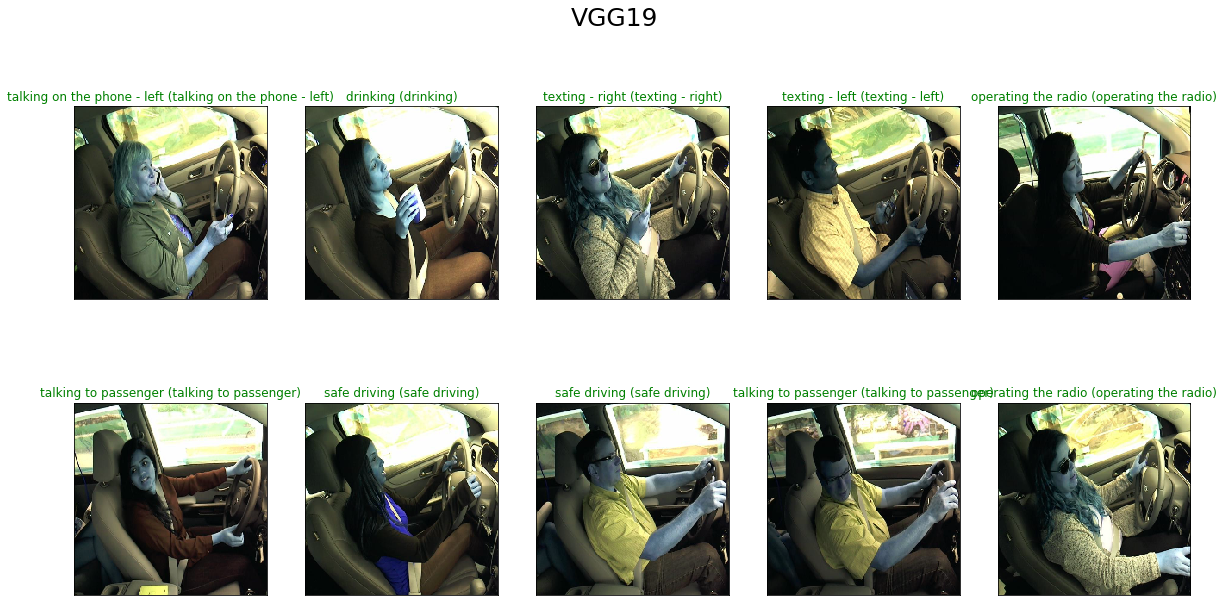

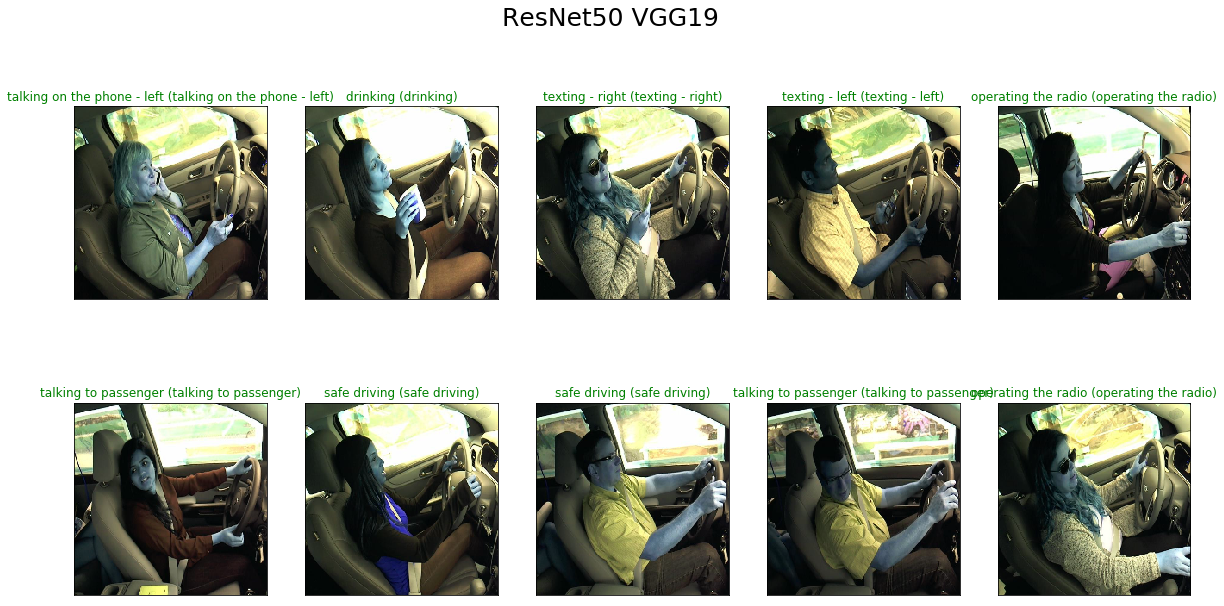

In [8]:
# Method that compiles all methods
# Loads dataset
# Preprocesses data
# Trains model
# tests the model
# Generates validation predictions score
# Returns score, train images,train targets/labels, validation score

def build_model(model_name,nfolds,epochs):
    print('Model: ', model_name)
    
    #intializes the fixed seed/random state
    random_state = 51
   
    #Loads the train data from file or cache
    cache_path= os.path.join('cache','train_224.dat')
    if not os.path.isfile(cache_path):
        print('building train cache')
        train_files,train_targets,train_id, driver_id, unique_drivers = load_train()
        cache_data((train_files,train_targets,train_id, driver_id, unique_drivers),cache_path)
        print('train cache built')           
    else:
        print('Restore train from cache')
        (train_files,train_targets,train_id, driver_id, unique_drivers)=restore_data(cache_path)
    
    #intialize the dictionary that will store the validation predictions
    val_predictions = dict()
    val_score=[]
    # splits unique list into folds
    kf = KFold(n_splits=nfolds, shuffle=True, random_state=random_state)
    num_fold = 0
    # drivers are split into train and validation sets
    for train_drivers, test_drivers in kf.split(unique_drivers):
        #Loads model architecture
        model = get_model_arch(model_name)
        # Gets the drivers and data based on the K-fold
        # Loads the data and labels
        unique_list_train = [unique_drivers[i] for i in train_drivers]
        X_train, Y_train  = get_selected_drivers(train_files, train_targets, driver_id, unique_list_train)
        unique_list_valid = [unique_drivers[i] for i in test_drivers]
        X_valid, Y_valid, test_index = get_val_selected_drivers(train_files, train_targets, driver_id, unique_list_valid)

        num_fold += 1
        print('Start KFold number {} of {}'.format(num_fold, nfolds))
        print('Train drivers: ', unique_list_train)
        print('Test drivers: ', unique_list_valid)
        
        # Divide each data point by 255 to normalize our data 
        X_valid/=255
        
        # Intialize Data augmentations
        train_datagen=ImageDataGenerator(
          rescale=1./255,
           zoom_range=0.4,
           width_shift_range=0.4,
           height_shift_range=0.4, 
           rotation_range=0.2
            )

        # Convert our labels to categorical using one-hot encode
        Y_train=np_utils.to_categorical(Y_train,10)
        Y_valid=np_utils.to_categorical(Y_valid,10)
        
        # Initialize weight path    
        if not os.path.isdir(os.path.join('cache')):
            os.mkdir(os.path.join('cache'))  
            
        kfold_weights_path = os.path.join('cache', 'weights_kfold_augmented_'+ model_name + '_' +  str(num_fold) + '.h5')
        
        # Check if weights already exist 
        if not os.path.isfile(kfold_weights_path) :
            
            # Initialize callbacks
            plot_losses = PlotLosses()
            callbacks = [
                EarlyStopping(monitor='val_loss', patience=8, verbose=0),
                plot_losses,
                ModelCheckpoint(kfold_weights_path, monitor='val_loss', save_best_only=True, verbose=2),
                
            ]
            
            #Convert our train data to float32
            X_train=X_train.astype('float32')
            
            print('--finished pre processing--')
            
            # Augment and train the model
            history=model.fit_generator(train_datagen.flow(X_train,Y_train,batch_size=batch_size,seed=random_state),
                            validation_data=(X_valid,Y_valid),
                    epochs=epochs ,use_multiprocessing=False,steps_per_epoch=len(X_train)/batch_size,
                            callbacks=callbacks,verbose=0) 
        #load weights
        if os.path.isfile(kfold_weights_path):
            model.load_weights(kfold_weights_path)

        del X_train
        
        # Generate validation data predictions and score
        pred_result = model.predict(X_valid, batch_size=batch_size, verbose=0)
        score = log_loss(Y_valid, pred_result)
        print('Score log_loss: ', score)
        # Store validation score
        val_score.append(score)
        # Store validation prediction results in the dictionary
        # Orders predictions to match the index
        for i in range(len(test_index)):
            val_predictions[test_index[i]] = pred_result[i]
        
        # Release variables accessing data
        del test_index
        del train_datagen
        del model
        del pred_result
        del X_valid
    
    print('train length: ', len(train_files))    
    
    score_sum=sum(val_score)
    score_sum/=nfolds
    print('Validation Score Average ', score_sum)
    # Converts the val_predictions dictionary to a list
    val_predictions = get_val_predictions(train_files, val_predictions)
    # Get complete dataset validation score
    train_targets=np_utils.to_categorical(train_targets,10)
    score = log_loss(train_targets, val_predictions)
    #Score model
    print('(validation score) Final log_loss: {}, nfolds: {} epoch: {}'.format(score, nfolds, epochs))
    return val_predictions,train_files,train_targets,val_score


# Method that loops the build_model method to the number of models
# Combines predictions of multiple models
# Calls the visualization methods
# Calls the method to build the Test Dataset predictions and Submission file
def train_selected_models(model_list,nfolds,epochs,build_submission):
    multi_model=[]
    train_targets=None
    train_files=None
    model_val_scores=[]
    # Execute each model- using build_model
    # Save return values
    for i in range(len(model_list)):
        result,train_files,train_targets,val_score=build_model(model_list[i],nfolds,epochs)
        multi_model.append(result)
        model_val_scores.append(val_score)
        
    num_models=len(multi_model)
    print("***FINAL MODEL RESULTS***") 
    
    for i in range(len(model_list)):
        score=log_loss(train_targets,multi_model[i])
        print('{} Final log_loss: {}, nfolds: {} epoch: {}'.format(model_list[i],score, nfolds, epochs))
     
    
    #Merge multiple model results and score the results
    result=merge_prediction_outputs(multi_model, num_models)
    score=log_loss(train_targets,result)
    print("Multi Model Log_loss Validation Score: {} ".format(score)) 
    
    #Creates the scores plot 
    visualize_val_score(model_list,model_val_scores,nfolds)
    #Creates sample images
    visualize_val_images(model_list,multi_model,train_files,train_targets,result)
    
   
    #If true, it build the submission results
    if build_submission == True:
        test_set_submission(model_list,nfolds,score)
        
    
# The one line to run it all !!
train_selected_models(model_list,nfolds,epochs,build_submission)